In [11]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import geopandas as gpd
from fiona.crs import from_epsg
%matplotlib inline

In [54]:
#load shape census tracts from:
#http://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nyct2010_16d.zip
shape_path = 'data/nyct2010_16d/nyct2010.shp'
nyc = gpd.GeoDataFrame.from_file(shape_path)
nyc.index=nyc.BoroCT2010
nyc.head()

,BoroCT2010,BoroCode,BoroName,CDEligibil,CT2010,CTLabel,NTACode,NTAName,PUMA,Shape_Area,Shape_Leng,geometry
BoroCT2010,,,,,,,,,,,,
5000900,5000900,5,Staten Island,I,000900,9,SI22,West New Brighton-New Brighton-St. George,3903,2.497010e+06,7729.016794,"POLYGON ((962269.1260375977 173705.5001831055,..."
5007400,5007400,5,Staten Island,I,007400,74,SI14,Grasmere-Arrochar-Ft. Wadsworth,3902,5.788238e+06,9902.948473,"POLYGON ((967656.8290405273 155637.1314086914,..."
1009800,1009800,1,Manhattan,I,009800,98,MN19,Turtle Bay-East Midtown,3808,1.906016e+06,5534.199811,"POLYGON ((994133.507019043 214848.8975830078, ..."
1010000,1010000,1,Manhattan,I,010000,100,MN19,Turtle Bay-East Midtown,3808,1.860938e+06,5692.168737,"POLYGON ((993108.3057861328 216013.1307983398,..."
1010200,1010200,1,Manhattan,I,010200,102,MN17,Midtown-Midtown South,3807,1.860993e+06,5687.802439,"POLYGON ((992216.5391845703 216507.6870117188,..."


In [55]:
#Coordinates
#original projection 
#http://www1.nyc.gov/assets/planning/download/pdf/data-maps/open-data/nyct2010_metadata.pdf?ver=16d
# epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet

nyc.crs = from_epsg(2263)


# if I wanted to change:
#NYC_Area=nyc.to_crs(epsg=2263).geometry.area.sum()/(2.788*10**7) # from ft2 to mi2 
#print 'total NYC land area: %s (mi^2)'%str(NYC_Area)[:5] # from ft2 to mi2 #epsg=2263 is US feet
print nyc.geometry.area.sum()
print nyc.Shape_Area.sum()

8429405956.99
8429401849.22


In [56]:
#download population data
nycPopulation=pd.read_csv('https://data.cityofnewyork.us/api/views/si4q-zuzm/rows.csv?accessType=DOWNLOAD',
                         dtype = {'Borough':unicode,'Year':int,'FIPS County Code':unicode,
                                 'DCP Borough Code':unicode,'Census Tract':unicode, 'Population':int})
nycPopulation['BoroCT2010'] = nycPopulation['DCP Borough Code'] + nycPopulation['Census Tract']
nycPopulation['BoroCT2010'] = nycPopulation['BoroCT2010'].astype(unicode)
nycPopulation.index = nycPopulation.BoroCT2010
nycPopulation.head()

,Borough,Year,FIPS County Code,DCP Borough Code,Census Tract,Population,BoroCT2010
BoroCT2010,,,,,,,
2000100,Bronx,2010,005,2,000100,11091,2000100
2000200,Bronx,2010,005,2,000200,4334,2000200
2000400,Bronx,2010,005,2,000400,5503,2000400
2001600,Bronx,2010,005,2,001600,5643,2001600
2001900,Bronx,2010,005,2,001900,1917,2001900


In [57]:
#nyc.loc[nyc.BoroName=='Bronx',:].head()

In [58]:
type(nycPopulation['BoroCT2010'][0])

unicode

In [59]:
type(nyc['BoroCT2010'][0])

unicode

In [60]:
nyc.BoroCT2010.isin(nycPopulation['BoroCT2010']).sum()

2166

In [61]:
nyc = nyc.merge(nycPopulation.loc[:,['BoroCT2010','Population']],on='BoroCT2010')
nyc.head()

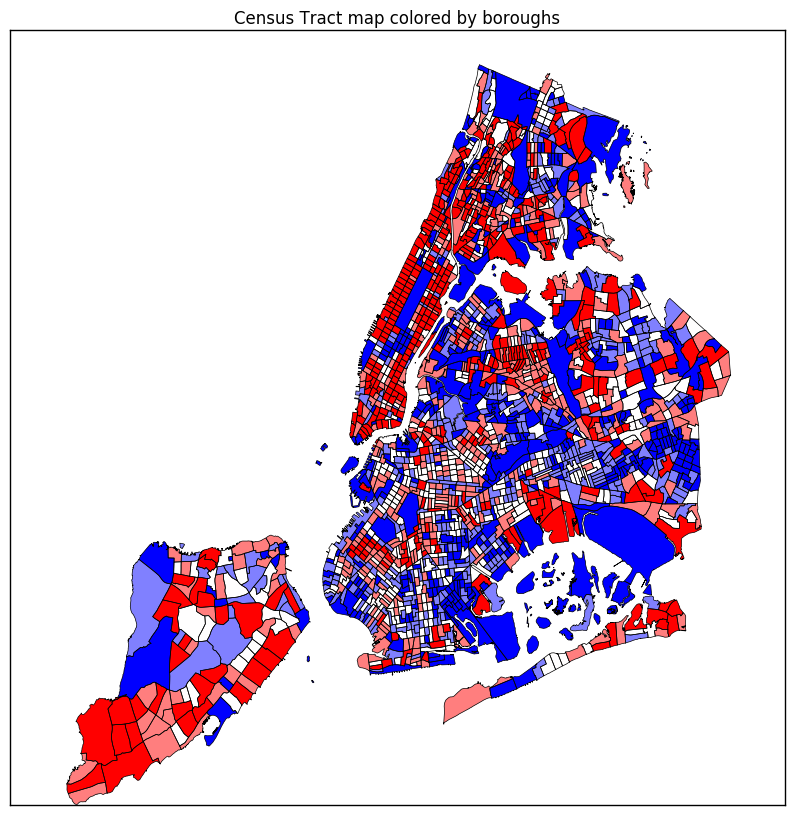

In [65]:
#PLOTING USING QUANTILES
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
nyc.plot(column='Population',
         alpha=1,
         linewidth=0.5,
         ax=ax,
         cmap = 'bwr',
         scheme='QUANTILES', #QUANTILES o fisher_jenks
)
plt.title("Census Tract map colored by boroughs")